# Experiment

In [22]:
import numpy as np
import scipy.ndimage
import scipy.signal
import matplotlib.pyplot as plt
from skimage import color, io, transform

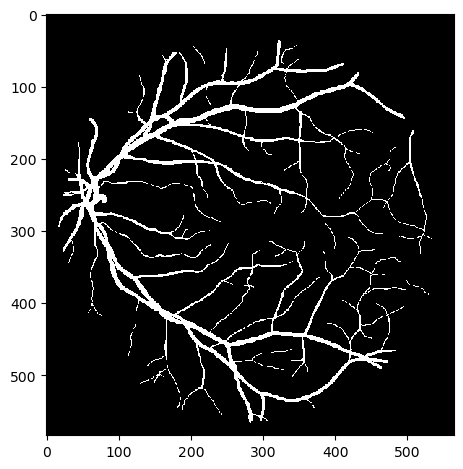

In [23]:
img = io.imread('data/DRIVE/training/1st_manual/21_manual1.gif')[0,:,:]

io.imshow(img)
io.show()

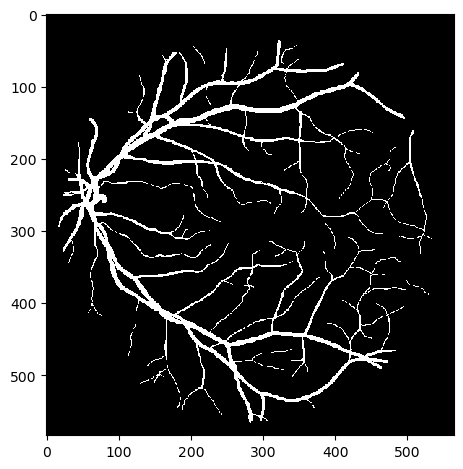

In [24]:
# img = img - np.mean(img)
# img = color.rgb2gray(img)


# img_smooth = scipy.ndimage.filters.gaussian_filter(img, sigma=1)
io.imshow(img, cmap='gray')
io.show()

In [25]:
def grad(x):
    return np.array(np.gradient(x))

def norm(x, axis=0):
    return np.sqrt(np.sum(np.square(x), axis=axis))

def stopping_fun(x):
    return 1. / (1. + norm(grad(x))**2)

F_v = stopping_fun(img)
print(img.shape)

(584, 565)


In [26]:
class TimeScheme(object):
	def __init__(self, dt):
		self.dt = dt

	def EulerForward(self, u, rhs, i, j):
		return u[i, j] - self.dt * rhs(u, i, j)

	def RungeKutta(self, u, rhs, i, j):
		k1 = rhs(u, i, j)
		k2 = rhs(u - 0.5*self.dt*k1, i, j)
		k3 = rhs(u - 0.5*self.dt*k2, i, j)
		k4 = rhs(u - self.dt*k3, i, j)
		return u[i, j] + self.dt*(k1 + 2*k2 + 2*k3 + k4)/6	

class SpatialScheme:
	@staticmethod
	def Upwind(u, i, j, ii, jj):
		return u[i, j] - u[ii, jj]


In [27]:
from matplotlib import colors


class levelset:
	def __init__(self,phi, dt, nt, timesch, spatialsch):
		self.phi=phi
		self.nx=phi.shape[0]
		self.ny=phi.shape[1]
		self.nt = nt
		self.dx=1.0/(self.nx-1)
		self.dy=1.0/(self.ny-1)
		self.dt=dt
		self.initialize()
		self.timesch=timesch
		self.spatialsch=spatialsch

	def initialize(self):
		for i in range(self.nx):
			for j in range(self.ny):
				# self.phi[i,j]=np.sqrt((i-self.nx/2)*(i-self.nx/2)+(j-self.ny/2)*(j-self.ny/2))-(self.nx/4)
				self.phi[i, j] = max(self.nx/8 - i, i - self.nx/3, self.ny/8 - j, j - self.ny/3)

	def boundary_condition(self, phi):
		phi[0, :] = phi[1, :]
		phi[-1, :] = phi[-2, :]
		phi[:, 0] = phi[:, 1]
		phi[:, -1] = phi[:, -2]
		return phi


	def reinitialize(self, step):
		phi0 = self.phi.copy()
		for _ in range(step):
			for i in range(1,self.nx-1):
				for j in range(1,self.ny-1):
					grad_phi_x = (phi0[i+1,j]-phi0[i-1,j])/(2 * self.dx)
					grad_phi_y = (phi0[i,j+1]-phi0[i,j-1])/(2 * self.dy)
					grad_phi = np.sqrt(grad_phi_x**2+grad_phi_y**2)
					s = phi0[i, j] / np.sqrt(phi0[i, j]**2 + (grad_phi*self.dx)**2)
					dphi = s * (grad_phi - 1)
					phi0[i, j] = phi0[i, j] - self.dt * dphi
			phi0 = self.boundary_condition(phi0)
		return phi0


	def F(self, i, j):
		return F_v[i,j]

	def rhs(self, phi, i, j):
		delt_xn = self.spatialsch(phi, i, j, i-1, j)
		delt_yn = self.spatialsch(phi, i, j, i, j-1)
		delt_xp = self.spatialsch(phi, i+1, j, i, j)
		delt_yp = self.spatialsch(phi, i, j+1, i, j)
		deltp = max(delt_xn/self.dx, 0)**2 + max(delt_yn/self.dy, 0)**2 + min(delt_xp/self.dx, 0)**2 + min(delt_yp/self.dy, 0)**2
		deltn = max(delt_xp/self.dx, 0)**2 + max(delt_yp/self.dy, 0)**2 + min(delt_xn/self.dx, 0)**2 + min(delt_yn/self.dy, 0)**2
		F = self.F(i,j)
		return max(F, 0) * np.sqrt(deltp) + min(F, 0) * np.sqrt(deltn)

	def evolve(self):
		for t in range(self.nt):
			if t % 10 == 0:
				# print(self.phi[self.phi<=0].shape)
				fig = self.phi.copy()
				fig[self.phi <= 0] = 255
				fig[self.phi > 0] = 0
				print(np.sum(np.logical_and(fig, img)/ np.sum(np.logical_or(img, fig))))
				# plt.contourf(fig, alpha=0.5)
				plt.contour(fig, levels=[0], colors = 'r')
				io.imshow(img)
				plt.title(f"time={t*self.dt}")
				plt.show()
			self.phi = self.boundary_condition(self.phi)
			for i in range(1,self.nx-1):
				for j in range(1,self.ny-1):
					self.phi[i, j] = self.timesch(self.phi, self.rhs, i, j)

			if t % 5 == 0:
				self.phi = self.reinitialize(10)

	

0.06050073317764623


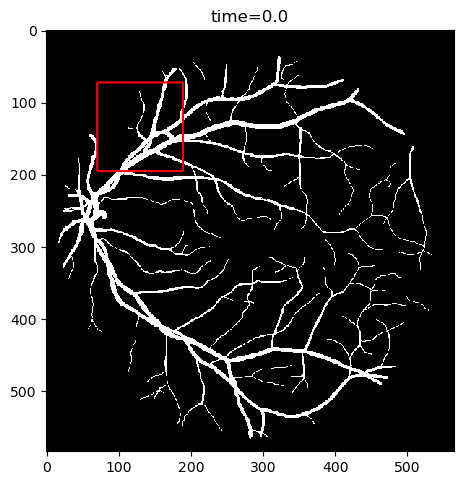

0.08486556071020862


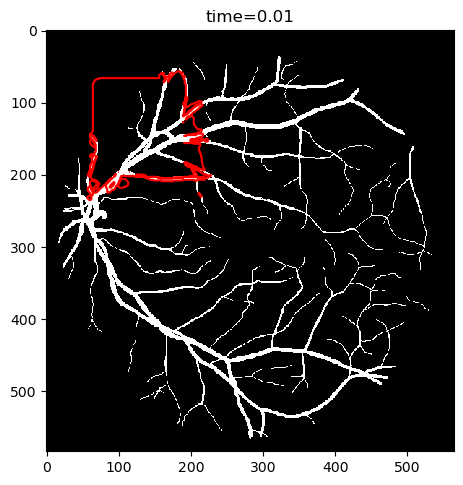

0.14732664394193992


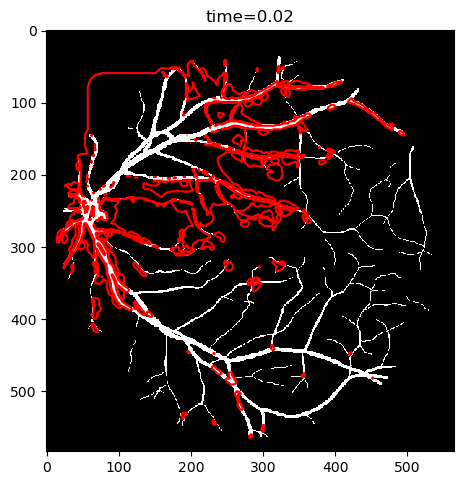

0.09016817184334908


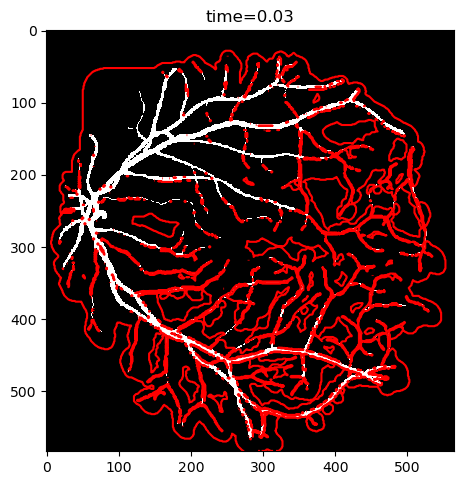

0.08077579543990725


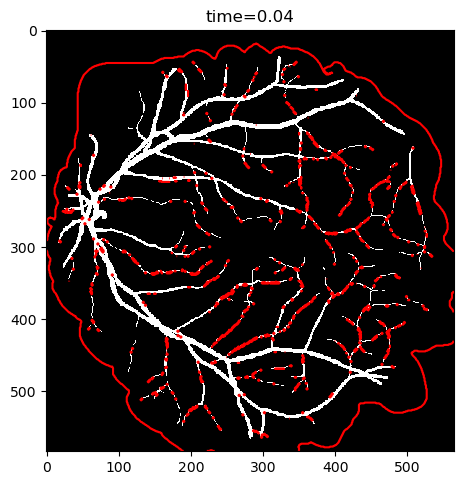

0.07659133842779363


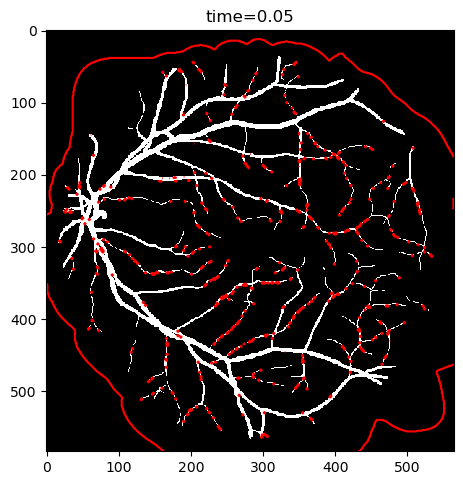

0.07291362052503446


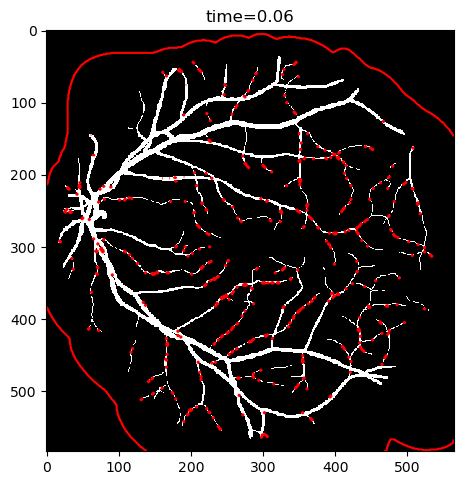

0.07073017520381271


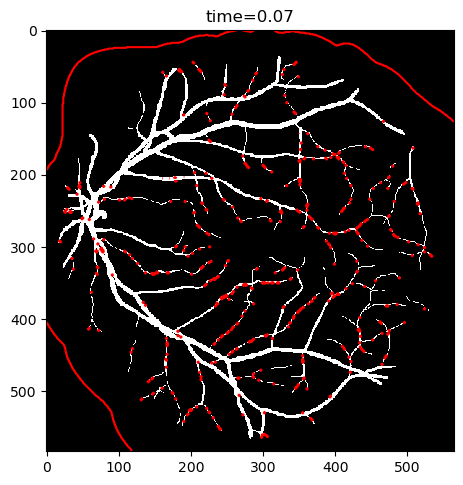

0.06906994952439655


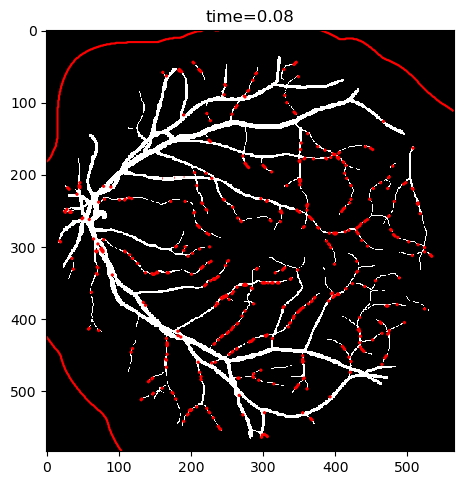

0.06772389338923114


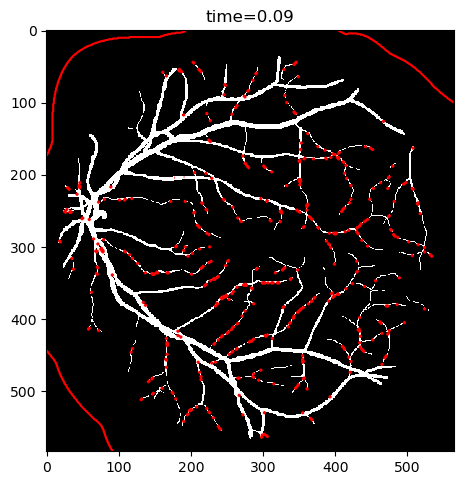

0.06657212889647471


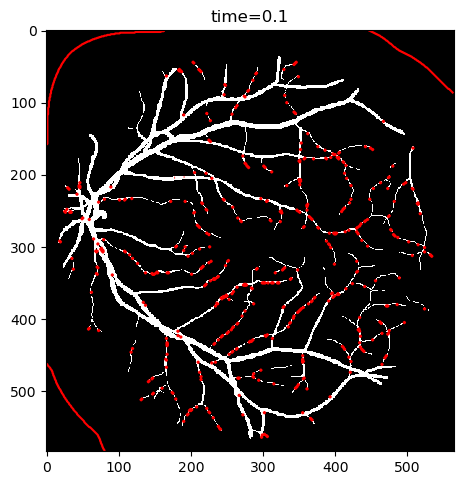

0.06570699523857766


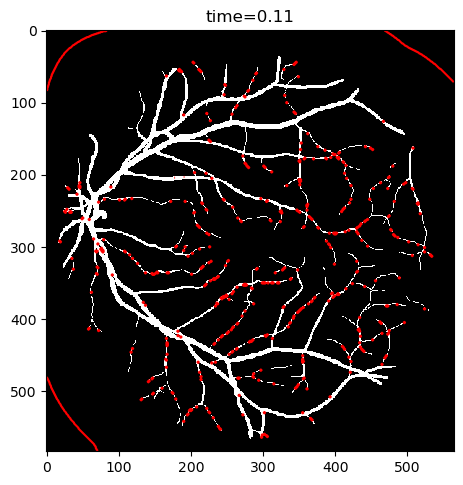

0.06510261539136815


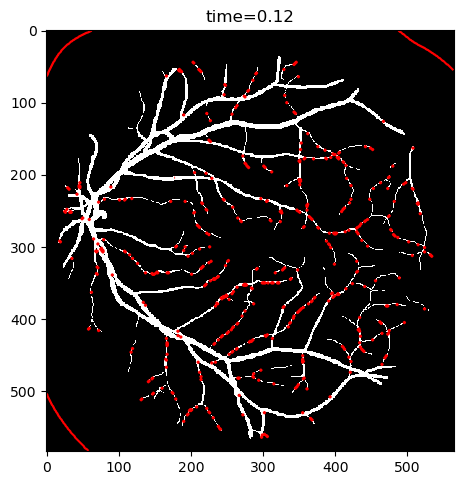

0.06464233358544123


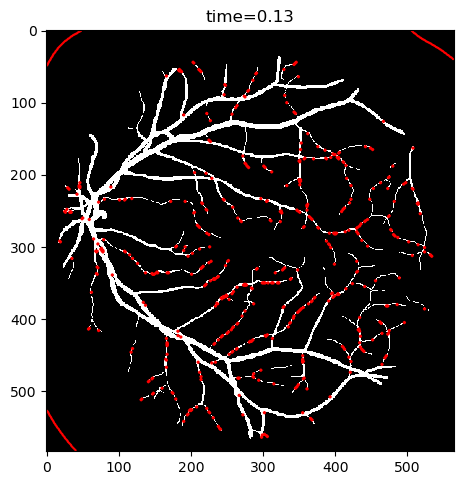

0.06432654375654133


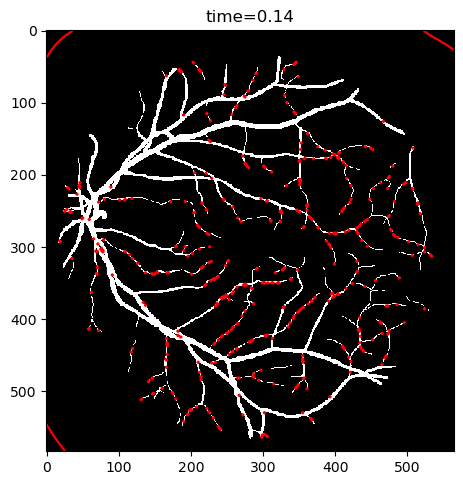

0.06412226934069123


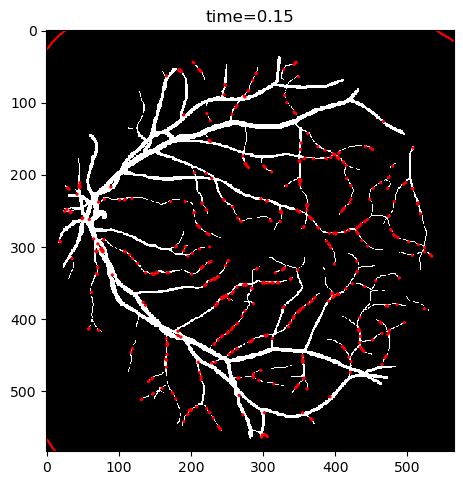

0.06403022468205223


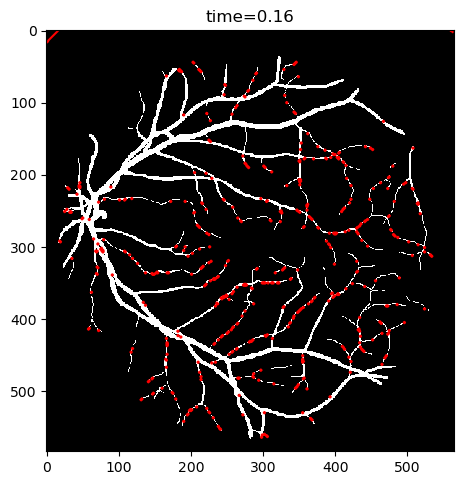

0.0640159192700793


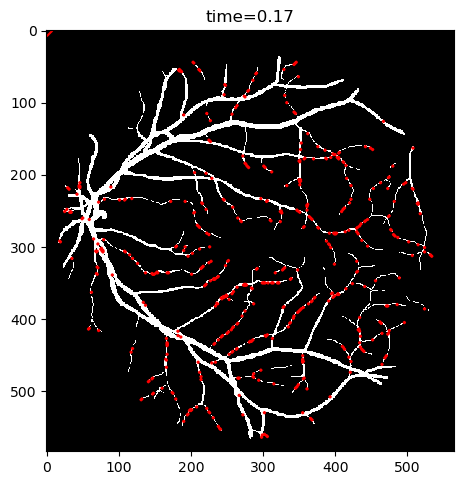

0.06401044666258081


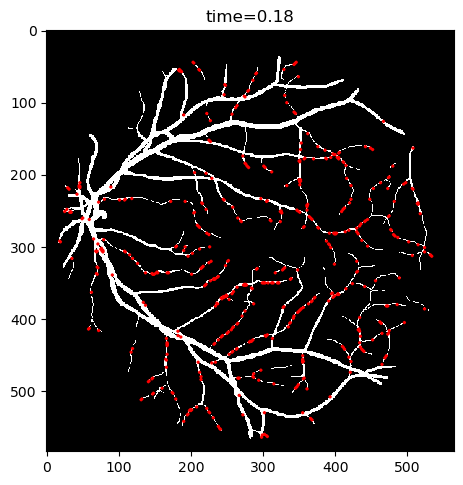

0.06401961116432049


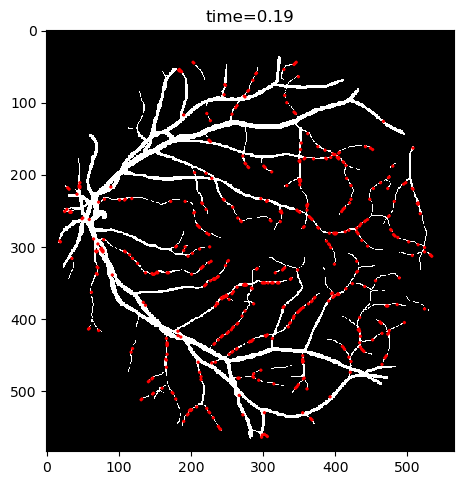

KeyboardInterrupt: 

In [28]:

phi = np.zeros(img.shape)
dt = 1e-3
nt = 20000
timesch = TimeScheme(dt)
spatialsch = SpatialScheme
solver = levelset(phi, dt, nt, timesch.EulerForward, spatialsch.Upwind)
solver.evolve()